# CSCI: 470 Final Project: 
## Predicting rates of violent crime given socio-economic data from communities in the United States
### Team H2Li: Heidi Hufford, Hannah Levy, and Lindsey Nield
---
**This code reads in the UCI Crime and Communities dataset (from a file stored on the computer) and does the following:**
- Splits the data into two datasets: a "community" dataset and a "police" dataset. This was done because it became obvious that this single dataset was made up of two different datasets, with differing numbers of observations
- Runs multiple linear regression on the community and police data to predict violent crime rate
- Runs principal component regression on the community and police data to predict violent crime rate. This was done because of the large number of features in each dataset.
- Runs lasso regression on the community and police data to predict violent crime rate. This is a shirnkage method that performs both variable selection and regularization. Again, it was used because of the large number of variables in the data sets.
- Converts continuous target to discrete target. The violent crime rates were classified as "low", "medium", or "high".
- Runs K-nearest neighbors algorithm on discrete target community and police data to predict level of violent crime
- Uses a feed-forward neural network to predict both rates and level of violent crime (discrete and continuous targets) for community and police data
-Uses feature importance procedures to determine feature importances of community data
-Uses top feature importances to construct "final" feed forward neural network

Note that there are two areas in the code where the dataset will need to uploaded. The first place is in the beginning, where the data is used for machine learning and predictive purposes. The second area is for the feature importance section; this was done to make ensure that the data being used for feature importance was not changed during the training and testing section. 

## Read in Data

In [0]:
#Set up code
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk

from pandas import Series, DataFrame
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

%matplotlib inline
plt.style.use("ggplot")

In [2]:
#Read in raw data
#Must have "communites.csv" on local drive
#Data can be downloaded from (http://archive.ics.uci.edu/ml/datasets/communities+and+crime) and saved as a csv 

from google.colab import files
uploaded = files.upload()

import io
raw_data = pd.read_csv(io.BytesIO(uploaded['communities.csv']))

MessageError: ignored

In [4]:
#Ensure data has been imported correctly
raw_data.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,...,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,...,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,...,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,...,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,...,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


## Data Preprocessing

In [0]:
#Replace '?' with NA values
raw_data = raw_data.replace('?', np.NaN)

In [6]:
#Find out more about our data
raw_data.describe(include="all")

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,...,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
count,1994.000000,820,817,1994,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1993,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,1994.000000,1994.000000,1994.000000,319,319,319,319,1994.000000,319,1994.000000
unique,NaN,108,799,1828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,52,34,55,44,59,75,52,76,74,73,54,50,72,30,15,77,NaN,NaN,NaN,63,38,72,3,NaN,51,NaN
top,NaN,3,52980,Greenvillecity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.1,0.98,0.19,0.02,0.14,0.23,0.1,0.78,0.97,0,0,0,0.07,0.03,0.57,0.19,NaN,NaN,NaN,0.02,0.02,0.74,0,NaN,0.12,NaN
freq,NaN,72,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,19,81,17,55,23,15,19,12,11,23,72,189,14,48,54,12,NaN,NaN,NaN,27,69,13,126,NaN,22,NaN
mean,28.683551,NaN,NaN,NaN,5.493982,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,0.424218,0.493867,0.336264,0.423164,0.064072,0.696269,0.361123,0.558154,0.291570,0.495687,0.471133,0.317778,0.479248,0.375677,0.350251,0.368049,0.291098,0.203506,0.322357,NaN,0.386279,0.055507,0.303024,0.315807,0.383330,0.361675,0.363531,0.501073,0.396384,...,0.372457,0.422964,0.384102,0.490125,0.449754,0.403816,0.029438,0.022778,0.215552,0.608892,0.535050,0.626424,0.651530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065231,0.232854,0.161685,NaN,NaN,NaN,NaN,0.094052,NaN,0.237979
std,16.397553,NaN,NaN,NaN,2.873694,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,0.155196,0.143564,0.166505,0.179185,0.128256,0.444811,0.209362,0.182913,0.204108,0.178071,0.173619,0.222137,0.167564,0.198257,0.191109,0.186804,0.171593,0.164775,0.195411,NaN,0.183081,0.127941,0.228474,0.213360,0.202508,0.209193,0.202171,0.174036,0.202386,...,0.209278,0.248286,0.213404,0.169500,0.187274,0.192593,0.102607,0.100400,0.231134,0.204329,0.181352,0.200521,0.198221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.109459,0.203092,0.229055,NaN,NaN,NaN,NaN,0.240328,NaN,0.232985
min,1.00

In [7]:
#Check how many values in each column are null
raw_data.isna().sum()

state                     0
county                 1174
community              1177
communityname             0
fold                      0
                       ... 
LemasPctPolicOnPatr    1675
LemasGangUnitDeploy    1675
LemasPctOfficDrugUn       0
PolicBudgPerPop        1675
ViolentCrimesPerPop       0
Length: 128, dtype: int64

In [0]:
#Remove fold column
raw_data = raw_data.drop(columns=["fold"])

In [0]:
#Remove the state, county, community, and community name columns
#Create dataframe of community statistics (1993 observations)
community_data = raw_data.copy()
community_data = community_data.drop(columns=["state", "county", "community", "communityname"])

community_data = community_data[[c for c in community_data if community_data[c].isnull().sum() < 1000]]
community_data.dropna(inplace=True)

In [0]:
#Create dataframe of crime/police statistics (319 observations)
police_data = raw_data[['LemasSwornFT',	'LemasSwFTPerPop',	'LemasSwFTFieldOps',	'LemasSwFTFieldPerPop',	'LemasTotalReq',	'LemasTotReqPerPop',	'PolicReqPerOffic',	'PolicPerPop',	'RacialMatchCommPol',	'PctPolicWhite',	'PctPolicBlack',	'PctPolicHisp',	'PctPolicAsian',	'PctPolicMinor',	'OfficAssgnDrugUnits',	'NumKindsDrugsSeiz',	'PolicAveOTWorked',	'PolicCars',	'PolicOperBudg',	'LemasPctPolicOnPatr',	'LemasGangUnitDeploy',	'PolicBudgPerPop', 'ViolentCrimesPerPop']].copy()
police_data.dropna(inplace=True)

In [11]:
#Creaate dataframe of all data
raw_data = raw_data.drop(columns=["state", "county", "community", "communityname"])
raw_data.dropna(inplace=True)
raw_data.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.00,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.00,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
16,0.15,0.31,0.40,0.63,0.14,0.06,0.58,0.72,0.65,0.47,0.16,1.00,0.22,0.52,0.10,0.51,0.48,0.39,0.51,0.30,0.29,0.34,0.23,0.13,0.20,0.2,0.30,0.15,0.48,0.30,0.38,0.47,0.37,0.44,0.08,0.73,0.21,0.53,0.50,0.94,...,0.32,0.36,0.33,0.52,0.35,0.40,0.23,0.02,0.23,0.80,0.41,0.53,0.80,0.06,0.3,0.93,0.38,0.05,0.21,0.23,0.3,0.61,0.89,0.15,0.01,0.06,0.12,0.1,0.64,0.22,0.06,0.39,0.84,0.06,0.06,0.91,0.5,0.88,0.26,0.49
20,0.25,0.54,0.05,0.71,0.48,0.30,0.42,0.48,0.28,0.32,0.26,1.00,0.33,0.55,0.37,0.37,0.39,0.64,0.44,0.32,0.29,0.32,0.23,0.17,0.17,0.24,0.30,0.19,0.34,0.34,0.43,0.24,0.59,0.43,0.38,0.41,0.43,0.36,0.60,0.35,...,0.40,0.45,0.40,0.65,0.59,0.21,0.12,0.09,0.38,0.58,0.31,0.48,0.73,0.03,0.08,0.96,0.12,0.05,0.11,0.35,0.08,0.8,0.82,0.04,0.19,0.19,0.18,0.05,0.57,0.36,0.09,0.46,0.05,0.09,0.05,0.88,0.5,0.76,0.13,0.34
21,1.00,0.42,0.47,0.59,0.12,0.05,0.41,0.53,0.34,0.33,1.00,0.99,0.28,0.62,0.16,0.36,0.40,0.30,0.45,0.29,0.30,0.35,0.21,0.20,0.33,0.28,0.40,0.76,0.33,0.25,0.39,0.28,0.30,0.59,0.18,0.33,0.35,0.38,0.69,0.41,...,0.28,0.32,0.30,0.45,0.41,0.32,0.39,0.36,0.10,0.44,0.45,0.60,0.48,0.25,0.16,0.75,0.19,0.35,0.19,0.38,0.16,0.82,0.7,0.45,0.03,0.05,0.33,0.13,0.57,1,1.00,0.07,0.15,1,0.35,0.73,0,0.31,0.21,0.69
23,0.11,0.43,0.04,0.89,0.09,0.06,0.45,0.48,0.31,0.46,0.13,1.00,0.22,0.52,0.44,0.49,0.56,0.41,0.39,0.25,0.25,0.25,0.16,0.07,0.20,0.19,0.22,0.10,0.36,0.29,0.37,0.27,0.33,0.53,0.43,0.47,0.44,0.33,0.48,0.39,...,0.17,0.18,0.17,0.44,0.20,0.43,0.05,0.01,0.09,0.72,0.58,0.72,0.64,0.01,0.11,0.98,0.14,0.03,0.14,0.37,0.11,0.84,0.96,0,0,0,0,0.02,0.86,0.29,0.16,0.12,0.07,0.04,0.01,0.81,1,0.56,0.09,0.63


In [12]:
community_data.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,...,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,...,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,...,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,...,0.08,0.56,0.62,0.85,0.77,1.00,0.94,0.12,0.01,0.5,0.01,0.97,0.96,0.60,0.47,0.52,0.11,0.11,0.24,0.21,0.19,0.75,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,0.38,0.42,0.46,0.22,0.27,...,0.05,0.16,0.19,0.59,0.60,0.37,0.89,0.02,0.19,0.5,0.01,0.89,0.87,0.04,0.55,0.73,0.05,0.14,0.31,0.31,0.30,0.40,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


In [13]:
police_data.head()

,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,PolicBudgPerPop,ViolentCrimesPerPop
0,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.06,0.04,0.9,0.5,0.14,0.20
16,0.06,0.3,0.93,0.38,0.05,0.21,0.23,0.3,0.61,0.89,0.15,0.01,0.06,0.12,0.1,0.64,0.22,0.06,0.06,0.91,0.5,0.26,0.49
20,0.03,0.08,0.96,0.12,0.05,0.11,0.35,0.08,0.8,0.82,0.04,0.19,0.19,0.18,0.05,0.57,0.36,0.09,0.05,0.88,0.5,0.13,0.34
21,0.25,0.16,0.75,0.19,0.35,0.19,0.38,0.16,0.82,0.7,0.45,0.03,0.05,0.33,0.13,0.57,1,1,0.35,0.73,0,0.21,0.69
23,0.01,0.11,0.98,0.14,0.03,0.14,0.37,0.11,0.84,0.96,0,0,0,0,0.02,0.86,0.29,0.04,0.01,0.81,1,0.09,0.63


#Regression Analysis

## Multiple Regression Model

### Using Community Data:

In [14]:
#Turn dataframe into a matrix
X_community = community_data.copy()
X_community = X_community.drop(['ViolentCrimesPerPop'], axis=1)
X_community = X_community.values

y_community = community_data['ViolentCrimesPerPop'].copy()
y_community = y_community.values


#Split the data
X_train_community, X_test_community, y_train_community, y_test_community = train_test_split(X_community, y_community, random_state=0, test_size=0.2)
#X_model_community, X_valid_community, y_model_community, y_valid_community = train_test_split(X_train_community, y_train_community, random_state=0, test_size=0.2)

print(f"All Data:        {len(X_community)} points")
print(f"Training data:   {len(X_train_community)} points")
print(f"Testing data:    {len(X_test_community)} points")

All Data:        1993 points
Training data:   1594 points
Testing data:    399 points


In [0]:
#Create regression object
regressor_community = LinearRegression()  

#Fit it to our training data
regressor_community.fit(X_train_community, y_train_community)

#Used fitted model to predict values
y_pred_community = regressor_community.predict(X_test_community)

In [16]:
#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_community, y_pred_community))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_community, y_pred_community))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_community, y_pred_community)))
print('Coefficient of Determination (R-squared):', metrics.r2_score(y_test_community, y_pred_community))

Mean Absolute Error: 0.09579858932346517
Mean Squared Error: 0.019674434520704453
Root Mean Squared Error: 0.14026558566057626
Coefficient of Determination (R-squared): 0.6623885467171884


### Using Police Data:

In [17]:
#Turn dataframe into a matrix
X_police = police_data.copy()
X_police = X_police.drop(['ViolentCrimesPerPop'], axis=1)
X_police = X_police.values

y_police = police_data['ViolentCrimesPerPop'].copy()
y_police = y_police.values


#Split the data
X_train_police, X_test_police, y_train_police, y_test_police = train_test_split(X_police, y_police, random_state=0, test_size=0.2)
#X_model_police, X_valid_police, y_model_police, y_valid_police = train_test_split(X_train_police, y_train_police, random_state=0, test_size=0.2)

print(f"All Data:        {len(X_police)} points")
print(f"Training data:   {len(X_train_police)} points")
print(f"Testing data:    {len(X_test_police)} points")

All Data:        319 points
Training data:   255 points
Testing data:    64 points


In [0]:
#Create regression object
regressor_police = LinearRegression()  

#Fit it to our training data
regressor_police.fit(X_train_police, y_train_police)

#Used fitted model to predict values
y_pred_police = regressor_police.predict(X_test_police)

In [19]:
#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_police, y_pred_police))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_police, y_pred_police))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_police, y_pred_police)))
print('Coefficient of Determination (R-squared):', metrics.r2_score(y_test_police, y_pred_police))

Mean Absolute Error: 0.16007498736797776
Mean Squared Error: 0.04383009191491713
Root Mean Squared Error: 0.2093563753863663
Coefficient of Determination (R-squared): 0.4163327284618965


###Using Concatenated Data

In [20]:
#Turn dataframe into a matrix
X_raw = raw_data.copy()
X_raw = X_raw.drop(['ViolentCrimesPerPop'], axis=1)
X_raw = X_raw.values

y_raw = raw_data['ViolentCrimesPerPop'].copy()
y_raw = y_raw.values


#Split the data
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, random_state=0, test_size=0.2)

print(f"All Data:        {len(X_raw)} points")
print(f"Training data:   {len(X_train_raw)} points")
print(f"Testing data:    {len(X_test_raw)} points")

All Data:        319 points
Training data:   255 points
Testing data:    64 points


In [0]:
#Create regression object
regressor_raw = LinearRegression()  

#Fit it to our training data
regressor_raw.fit(X_train_raw, y_train_raw)

#Used fitted model to predict values
y_pred_raw = regressor_raw.predict(X_test_raw)

In [22]:
#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_raw, y_pred_raw))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_raw, y_pred_raw))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_raw, y_pred_raw)))
print('Coefficient of Determination (R-squared):', metrics.r2_score(y_test_raw, y_pred_raw))

Mean Absolute Error: 0.17939707585390618
Mean Squared Error: 0.05416436523957517
Root Mean Squared Error: 0.2327323897517816
Coefficient of Determination (R-squared): 0.27871546937786273


## Multiple Regression Model Using PCA (PCR)

### Using Community Data:

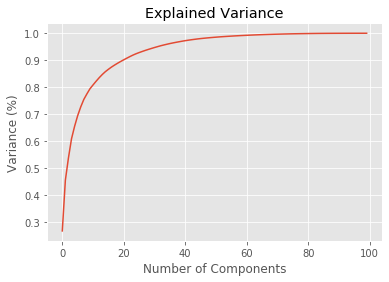

In [23]:
#Note: DATA IS ALREADY NORMALIZED

#Determine number of components
pca_num = PCA().fit(X_community)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca_num.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

#We will use 20 components

In [24]:
#Split the data
X_train_com_pca, X_test_com_pca, y_train_com_pca, y_test_com_pca = train_test_split(X_community, y_community, random_state=0, test_size=0.2)

#Create PCA object
pca_tf_com = PCA(n_components = 20)

#Transform the community data
X_train_com_pca = pca_tf_com.fit_transform(X_train_com_pca)
X_test_com_pca = pca_tf_com.transform(X_test_com_pca)

#Find the proportion of the data that is explained by the PCs
#We want ~90% of the variance explained (from above, 20 components)
pca_tf_com.explained_variance_ratio_

array([0.26459914, 0.18854542, 0.08313952, 0.07049245, 0.04511438,
       0.04024811, 0.03266295, 0.0286398 , 0.02171527, 0.01933594,
       0.01427367, 0.01396827, 0.01353577, 0.01171939, 0.01050239,
       0.00892626, 0.00764241, 0.00741589, 0.00676451, 0.00665744])

In [0]:
#Create regression object
regressor_community_pca = LinearRegression()  

#Fit it to our training data
regressor_community_pca.fit(X_train_com_pca, y_train_com_pca)

#Used fitted model to predict values
y_pred_com_pca = regressor_community_pca.predict(X_test_com_pca)

In [26]:
#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_com_pca, y_pred_com_pca))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_com_pca, y_pred_com_pca))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_com_pca, y_pred_com_pca)))
print('Coefficient of Determination (R-squared):', metrics.r2_score(y_test_com_pca, y_pred_com_pca))

Mean Absolute Error: 0.09938514628675815
Mean Squared Error: 0.020757555969442915
Root Mean Squared Error: 0.14407482767452098
Coefficient of Determination (R-squared): 0.643802284123183


### Using Police Data:

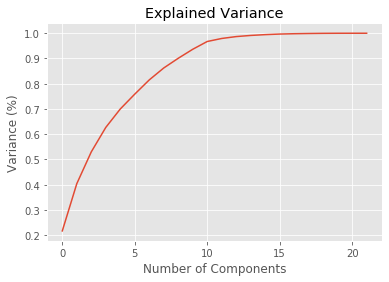

In [27]:
#Note: DATA IS ALREADY NORMALIZED

#Determine number of components
pca_num = PCA().fit(X_police)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca_num.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

#We will use 10 components

In [28]:
#Turn dataframe into a matrix
X_police = police_data.copy()
X_police = X_police.drop(['ViolentCrimesPerPop'], axis=1)
X_police = X_police.values

y_police = police_data['ViolentCrimesPerPop'].copy()
y_police = y_police.values

#Split the data
X_train_pl_pca, X_test_pl_pca, y_train_pl_pca, y_test_pl_pca = train_test_split(X_police, y_police, random_state=0, test_size=0.2)

#Create PCA object
pca_tf_pl = PCA(n_components = 10)

#Transform the community data
X_train_pl_pca = pca_tf_pl.fit_transform(X_train_pl_pca)
X_test_pl_pca = pca_tf_pl.transform(X_test_pl_pca)

#Find the proportion of the data that is explained by the PCs
#We want ~90% of the variance explained (from above, 10 components)
pca_tf_pl.explained_variance_ratio_

array([0.22103486, 0.1922623 , 0.12557389, 0.09389363, 0.07601779,
       0.05742806, 0.05600108, 0.04296736, 0.03892573, 0.03279199])

In [0]:
#Create regression object
regressor_police_pca = LinearRegression()  

#Fit it to our training data
regressor_police_pca.fit(X_train_pl_pca, y_train_pl_pca)

#Used fitted model to predict values
y_pred_pl_pca = regressor_police_pca.predict(X_test_pl_pca)

In [30]:
#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_pl_pca, y_pred_pl_pca))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_pl_pca, y_pred_pl_pca))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_pl_pca, y_pred_pl_pca)))
print('Coefficient of Determination (R-squared):', metrics.r2_score(y_test_pl_pca, y_pred_pl_pca))

Mean Absolute Error: 0.1715329068275443
Mean Squared Error: 0.05049861646524753
Root Mean Squared Error: 0.2247189721969365
Coefficient of Determination (R-squared): 0.3275307351411494


###Using Concatenated Data

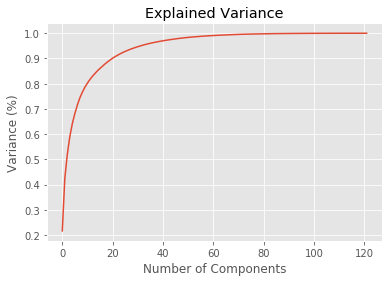

In [65]:
#Note: DATA IS ALREADY NORMALIZED

#Determine number of components
pca_num = PCA().fit(X_raw)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca_num.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

#We will use 40 components

In [67]:
#Turn dataframe into a matrix
X_raw = raw_data.copy()
X_raw = X_raw.drop(['ViolentCrimesPerPop'], axis=1)
X_raw = X_raw.values

y_raw = raw_data['ViolentCrimesPerPop'].copy()
y_raw = y_raw.values

#Split the data
X_train_raw_pca, X_test_raw_pca, y_train_raw_pca, y_test_raw_pca = train_test_split(X_raw, y_raw, random_state=0, test_size=0.2)

#Create PCA object
pca_tf_raw = PCA(n_components = 40)

#Transform the community data
X_train_raw_pca = pca_tf_raw.fit_transform(X_train_raw_pca)
X_test_raw_pca = pca_tf_raw.transform(X_test_raw_pca)

#Find the proportion of the data that is explained by the PCs
#We want ~90% of the variance explained (from above, 40 components)
pca_tf_raw.explained_variance_ratio_

array([0.22099434, 0.21753869, 0.09078503, 0.07180312, 0.04798012,
       0.03962102, 0.03436936, 0.02986471, 0.02279177, 0.01871492,
       0.01506401, 0.01472329, 0.01173201, 0.01154062, 0.01028907,
       0.00941629, 0.00874655, 0.00836516, 0.00801172, 0.00719012,
       0.00666352, 0.00575071, 0.00559275, 0.00491167, 0.00473821,
       0.00443805, 0.0040369 , 0.00392974, 0.00378685, 0.00337179,
       0.00329159, 0.00286939, 0.00279298, 0.00254104, 0.00236087,
       0.00231984, 0.00222501, 0.00206727, 0.00202718, 0.00185003])

In [0]:
#Create regression object
regressor_raw_pca = LinearRegression()  

#Fit it to our training data
regressor_raw_pca.fit(X_train_raw_pca, y_train_raw_pca)

#Used fitted model to predict values
y_pred_raw_pca = regressor_raw_pca.predict(X_test_raw_pca)

In [69]:
#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_raw_pca, y_pred_raw_pca))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_raw_pca, y_pred_raw_pca))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_raw_pca, y_pred_raw_pca)))
print('Coefficient of Determination (R-squared):', metrics.r2_score(y_test_raw_pca, y_pred_raw_pca))

Mean Absolute Error: 0.14740234657134624
Mean Squared Error: 0.03600194008420643
Root Mean Squared Error: 0.1897417721120113
Coefficient of Determination (R-squared): 0.5205770003901034


## Regularization

### Lasso Using Community Data:

In [0]:
#Determine Coefficients

# Create some alpha values that we'll use to train several models
n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)

In [0]:
def determine_coefficients(alphas, model, X, y):
    """Determine the coefficients of a linear model (Lasso or Ridge) given the various alphas. 
    You should train a model for each value of alpha and store its coefficients to be returned.
    
    Args:
        alphas (iterable): The alphas to test out with the model
        model (sklearn.estimator Class): A type of linear model not instantiated
        X (iterable): The data to train on
        y (iterable): The labels to train on
        
    Returns:
        coefs (iterable): the coefficients extracted from the trained model. See model.coef_
    """
    
    coeff = []
    
    for i in alphas:
        clf = model(alpha=i, fit_intercept=False)
        model_fit = clf.fit(X, y) 
        c = model_fit.coef_ 
        coeff.append(c)
    return coeff

In [0]:
import warnings
warnings.filterwarnings("ignore")

lassoCoefs_com = determine_coefficients(alphas, Lasso, X_community, y_community)

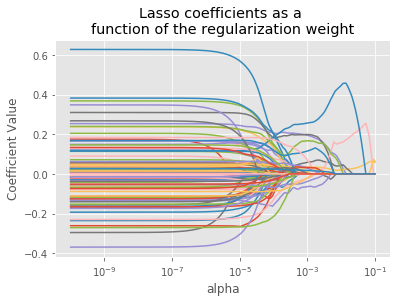

In [34]:
ax = plt.gca()

ax.plot(alphas, lassoCoefs_com)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficient Value')
plt.title('Lasso coefficients as a \nfunction of the regularization weight')
plt.axis('tight')
plt.show()

In [35]:
#Split the data
X_train_community, X_test_community, y_train_community, y_test_community = train_test_split(X_community, y_community, random_state=0, test_size=0.2)

#Create, fit, and predict
alpha = 0.01
lassoreg_com = Lasso(alpha=alpha, max_iter=1e-5)
lassoreg_com.fit(X_train_community,y_train_community)
y_pred_lasso_com = lassoreg_com.predict(X_test_community)

#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_community, y_pred_lasso_com))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_community, y_pred_lasso_com))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_community, y_pred_lasso_com)))
print('Coefficient of Determination (R-squared):', metrics.r2_score(y_test_community, y_pred_lasso_com))

Mean Absolute Error: 0.1842982770602793
Mean Squared Error: 0.05835375338080169
Root Mean Squared Error: 0.24156521558536048
Coefficient of Determination (R-squared): -0.0013449414602968446


### Lasso Using Police Data:

In [0]:
#Determine coefficients
import warnings
warnings.filterwarnings("ignore")

lassoCoefs_pl = determine_coefficients(alphas, Lasso, X_police, y_police)

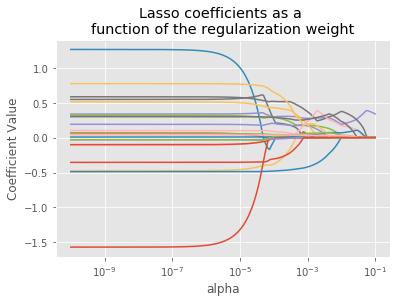

In [37]:
ax = plt.gca()

ax.plot(alphas, lassoCoefs_pl)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficient Value')
plt.title('Lasso coefficients as a \nfunction of the regularization weight')
plt.axis('tight')
plt.show()

In [38]:
#Split the data
X_train_pl, X_test_pl, y_train_pl, y_test_pl = train_test_split(X_police, y_police, random_state=0, test_size=0.2)

#Create, fit, and predict
alpha = 0.001
lassoreg_pl = Lasso(alpha=alpha, max_iter=1e5)
lassoreg_pl.fit(X_train_pl, y_train_pl)
y_pred_lasso_pl = lassoreg_pl.predict(X_test_pl)

#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_pl, y_pred_lasso_pl))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_pl, y_pred_lasso_pl))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_pl, y_pred_lasso_pl)))
print('Coefficient of Determination (R-squared):', metrics.r2_score(y_test_pl, y_pred_lasso_pl))

Mean Absolute Error: 0.1664510939232329
Mean Squared Error: 0.04626678235216719
Root Mean Squared Error: 0.21509714631339763
Coefficient of Determination (R-squared): 0.38388432607539147


###Using Concatenated Data:

In [0]:
#Determine coefficients
import warnings
warnings.filterwarnings("ignore")

lassoCoefs_raw = determine_coefficients(alphas, Lasso, X_raw, y_raw)

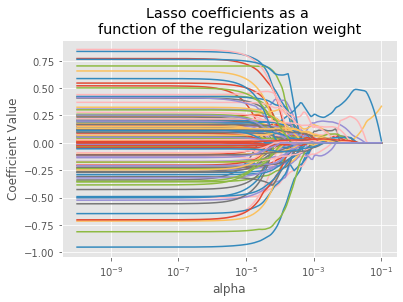

In [72]:
ax = plt.gca()

ax.plot(alphas, lassoCoefs_raw)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficient Value')
plt.title('Lasso coefficients as a \nfunction of the regularization weight')
plt.axis('tight')
plt.show()

In [0]:
#Split the data
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, random_state=0, test_size=0.2)

#Create, fit, and predict
alpha = 0.0001
lassoreg_raw = Lasso(alpha=alpha, max_iter=1e5)
lassoreg_raw.fit(X_train_raw, y_train_raw)
y_pred_lasso_raw = lassoreg_raw.predict(X_test_raw)

In [74]:
#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_raw, y_pred_lasso_raw))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_raw, y_pred_lasso_raw))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_raw, y_pred_lasso_raw)))
print('Coefficient of Determination (R-squared):', metrics.r2_score(y_test_raw, y_pred_lasso_raw))

Mean Absolute Error: 0.15392661750198788
Mean Squared Error: 0.04102884701440655
Root Mean Squared Error: 0.20255578741276822
Coefficient of Determination (R-squared): 0.4536357524018162


#Classification Analysis

###Create Dataset with Classifcation Targets
We take our community and police data sets and convert the target (Violent crime per capita) into discrete targets: Low (<0.33), Medium (<0.66), and High (<1). Note that our data is standardized.

In [39]:
#Find max and min of normalized data
print(community_data['ViolentCrimesPerPop'].max())
print(community_data['ViolentCrimesPerPop'].min())

print(police_data['ViolentCrimesPerPop'].max())
print(police_data['ViolentCrimesPerPop'].min())

1.0
0.0
1.0
0.02


In [0]:
#Create function that will sort continuous targets into classes
def crime_class(x):
    if x <= 0.33:
        return "L"
    elif x <= 0.66:
        return "M"
    else: return "H"

In [41]:
#Make targets discrete
community_data_class = community_data.copy()
community_data_class['ViolentCrimeLevel'] = community_data_class['ViolentCrimesPerPop'].apply(crime_class)
community_data_class = community_data_class.drop(['ViolentCrimesPerPop'], axis=1)
community_data_class.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimeLevel
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,...,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,L
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,...,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,H
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,...,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,M
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,...,0.08,0.56,0.62,0.85,0.77,1.00,0.94,0.12,0.01,0.5,0.01,0.97,0.96,0.60,0.47,0.52,0.11,0.11,0.24,0.21,0.19,0.75,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,L
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,0.38,0.42,0.46,0.22,0.27,...,0.05,0.16,0.19,0.59,0.60,0.37,0.89,0.02,0.19,0.5,0.01,0.89,0.87,0.04,0.55,0.73,0.05,0.14,0.31,0.31,0.30,0.40,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,L


In [42]:
#Make targets discrete
police_data_class = police_data.copy()
police_data_class['ViolentCrimeLevel'] = police_data_class['ViolentCrimesPerPop'].apply(crime_class)
police_data_class = police_data_class.drop(['ViolentCrimesPerPop'], axis=1)
police_data_class.head()

,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,PolicBudgPerPop,ViolentCrimeLevel
0,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.06,0.04,0.9,0.5,0.14,L
16,0.06,0.3,0.93,0.38,0.05,0.21,0.23,0.3,0.61,0.89,0.15,0.01,0.06,0.12,0.1,0.64,0.22,0.06,0.06,0.91,0.5,0.26,M
20,0.03,0.08,0.96,0.12,0.05,0.11,0.35,0.08,0.8,0.82,0.04,0.19,0.19,0.18,0.05,0.57,0.36,0.09,0.05,0.88,0.5,0.13,M
21,0.25,0.16,0.75,0.19,0.35,0.19,0.38,0.16,0.82,0.7,0.45,0.03,0.05,0.33,0.13,0.57,1,1,0.35,0.73,0,0.21,H
23,0.01,0.11,0.98,0.14,0.03,0.14,0.37,0.11,0.84,0.96,0,0,0,0,0.02,0.86,0.29,0.04,0.01,0.81,1,0.09,M


In [75]:
#Make targets discrete
raw_data_class = raw_data.copy()
raw_data_class['ViolentCrimeLevel'] = raw_data_class['ViolentCrimesPerPop'].apply(crime_class)
raw_data_class = raw_data_class.drop(['ViolentCrimesPerPop'], axis=1)
raw_data_class.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimeLevel
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.00,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.00,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,L
16,0.15,0.31,0.40,0.63,0.14,0.06,0.58,0.72,0.65,0.47,0.16,1.00,0.22,0.52,0.10,0.51,0.48,0.39,0.51,0.30,0.29,0.34,0.23,0.13,0.20,0.2,0.30,0.15,0.48,0.30,0.38,0.47,0.37,0.44,0.08,0.73,0.21,0.53,0.50,0.94,...,0.32,0.36,0.33,0.52,0.35,0.40,0.23,0.02,0.23,0.80,0.41,0.53,0.80,0.06,0.3,0.93,0.38,0.05,0.21,0.23,0.3,0.61,0.89,0.15,0.01,0.06,0.12,0.1,0.64,0.22,0.06,0.39,0.84,0.06,0.06,0.91,0.5,0.88,0.26,M
20,0.25,0.54,0.05,0.71,0.48,0.30,0.42,0.48,0.28,0.32,0.26,1.00,0.33,0.55,0.37,0.37,0.39,0.64,0.44,0.32,0.29,0.32,0.23,0.17,0.17,0.24,0.30,0.19,0.34,0.34,0.43,0.24,0.59,0.43,0.38,0.41,0.43,0.36,0.60,0.35,...,0.40,0.45,0.40,0.65,0.59,0.21,0.12,0.09,0.38,0.58,0.31,0.48,0.73,0.03,0.08,0.96,0.12,0.05,0.11,0.35,0.08,0.8,0.82,0.04,0.19,0.19,0.18,0.05,0.57,0.36,0.09,0.46,0.05,0.09,0.05,0.88,0.5,0.76,0.13,M
21,1.00,0.42,0.47,0.59,0.12,0.05,0.41,0.53,0.34,0.33,1.00,0.99,0.28,0.62,0.16,0.36,0.40,0.30,0.45,0.29,0.30,0.35,0.21,0.20,0.33,0.28,0.40,0.76,0.33,0.25,0.39,0.28,0.30,0.59,0.18,0.33,0.35,0.38,0.69,0.41,...,0.28,0.32,0.30,0.45,0.41,0.32,0.39,0.36,0.10,0.44,0.45,0.60,0.48,0.25,0.16,0.75,0.19,0.35,0.19,0.38,0.16,0.82,0.7,0.45,0.03,0.05,0.33,0.13,0.57,1,1.00,0.07,0.15,1,0.35,0.73,0,0.31,0.21,H
23,0.11,0.43,0.04,0.89,0.09,0.06,0.45,0.48,0.31,0.46,0.13,1.00,0.22,0.52,0.44,0.49,0.56,0.41,0.39,0.25,0.25,0.25,0.16,0.07,0.20,0.19,0.22,0.10,0.36,0.29,0.37,0.27,0.33,0.53,0.43,0.47,0.44,0.33,0.48,0.39,...,0.17,0.18,0.17,0.44,0.20,0.43,0.05,0.01,0.09,0.72,0.58,0.72,0.64,0.01,0.11,0.98,0.14,0.03,0.14,0.37,0.11,0.84,0.96,0,0,0,0,0.02,0.86,0.29,0.16,0.12,0.07,0.04,0.01,0.81,1,0.56,0.09,M


##K-Nearest Neighbors

###Community Data:

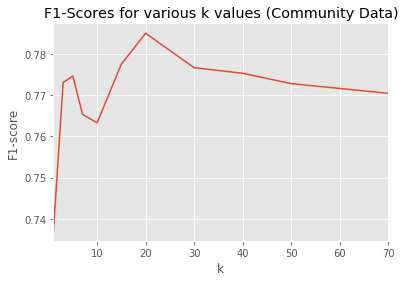

In [43]:
#Turn dataframe into a matrix
X_c_class = community_data_class.copy()
X_c_class = X_c_class.drop(['ViolentCrimeLevel'], axis=1)
X_c_class = X_c_class.values

y_c_class = community_data_class['ViolentCrimeLevel'].copy()
y_c_class = y_c_class.values

#Split the data into training and test data
X_train_c_knn, X_test_c_knn, y_train_c_knn, y_test_c_knn = train_test_split(X_c_class, y_c_class, random_state=0, test_size=0.2)

#Train a model on the training dataset then return the F-1 score on the test set   
#Initialize dictionary
f1_scores_k= dict()

ks = [1,3,5,7,10,15,20,30,40,50,70]
    
for i in ks:
    # Step 1 - Initialize model with parameters
    knn = KNeighborsClassifier(n_neighbors=i)
       
    # Step 2 - Fit the model data
    knn.fit(X_train_c_knn, y_train_c_knn)
        
    # Step 3 - Predict the test data
    class_predictions = knn.predict(X_test_c_knn)
        
    #Step 4 - Evaluate model using f1 score
    score = f1_score(y_test_c_knn, class_predictions, average="weighted")
        
    #Step 5 - Add key and value to dictionary
    f1_scores_k.update( {i : score} )
    
pd.Series(f1_scores_k).plot(kind="line")
plt.title("F1-Scores for various k values (Community Data)")
plt.xlabel("k")
plt.ylabel("F1-score")
plt.show()

We will use k=20 for our analysis:

In [44]:
bestK = 20
best_c_knn = KNeighborsClassifier(bestK)
best_c_knn.fit(X_train_c_knn, y_train_c_knn)
testPredictions = best_c_knn.predict(X_test_c_knn)

print("Confusion Matrix: \n")
print(confusion_matrix(y_test_c_knn, testPredictions))
print("\n\nClassification Report:\n")
print(classification_report(y_test_c_knn, testPredictions))

Confusion Matrix: 

[[  7  10  17]
 [  0 299   9]
 [  3  36  18]]


Classification Report:

              precision    recall  f1-score   support

           H       0.70      0.21      0.32        34
           L       0.87      0.97      0.92       308
           M       0.41      0.32      0.36        57

    accuracy                           0.81       399
   macro avg       0.66      0.50      0.53       399
weighted avg       0.79      0.81      0.78       399



###Police Data:

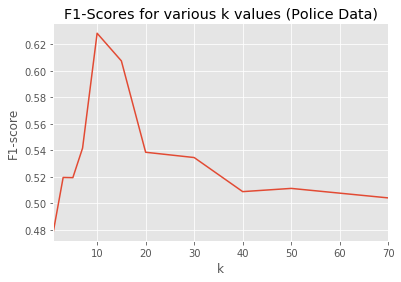

In [45]:
#Turn dataframe into a matrix
X_p_class = police_data_class.copy()
X_p_class = X_p_class.drop(['ViolentCrimeLevel'], axis=1)
X_p_class = X_p_class.values

y_p_class = police_data_class['ViolentCrimeLevel'].copy()
y_p_class = y_p_class.values

#Split the data into training and test data
X_train_p_knn, X_test_p_knn, y_train_p_knn, y_test_p_knn = train_test_split(X_p_class, y_p_class, random_state=0, test_size=0.2)

#Train a model on the training dataset then return the F-1 score on the test set   
#Initialize dictionary
f1_scores_k= dict()

ks = [1,3,5,7,10,15,20,30,40,50,70]
    
for i in ks:
    # Step 1 - Initialize model with parameters
    knn = KNeighborsClassifier(n_neighbors=i)
       
    # Step 2 - Fit the model data
    knn.fit(X_train_p_knn, y_train_p_knn)
        
    # Step 3 - Predict the test data
    class_predictions = knn.predict(X_test_p_knn)
        
    #Step 4 - Evaluate model using f1 score
    score = f1_score(y_test_p_knn, class_predictions, average="weighted")
        
    #Step 5 - Add key and value to dictionary
    f1_scores_k.update( {i : score} )
    
pd.Series(f1_scores_k).plot(kind="line")
plt.title("F1-Scores for various k values (Police Data)")
plt.xlabel("k")
plt.ylabel("F1-score")
plt.show()

We will use k=10 for our analysis:

In [46]:
bestK = 10
best_p_knn = KNeighborsClassifier(bestK)
best_p_knn.fit(X_train_p_knn, y_train_p_knn)
testPredictions = best_p_knn.predict(X_test_p_knn)

print("Confusion Matrix: \n")
print(confusion_matrix(y_test_p_knn, testPredictions))
print("\n\nClassification Report:\n")
print(classification_report(y_test_p_knn, testPredictions))

Confusion Matrix: 

[[ 5  3  7]
 [ 0 25  5]
 [ 2  6 11]]


Classification Report:

              precision    recall  f1-score   support

           H       0.71      0.33      0.45        15
           L       0.74      0.83      0.78        30
           M       0.48      0.58      0.52        19

    accuracy                           0.64        64
   macro avg       0.64      0.58      0.59        64
weighted avg       0.65      0.64      0.63        64



###Using Concatenated Data:

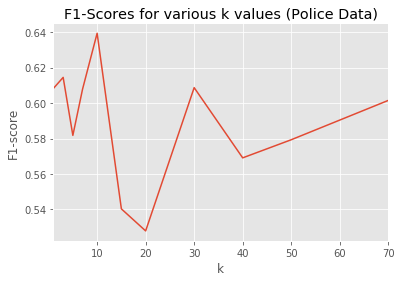

In [76]:
#Turn dataframe into a matrix
X_r_class = raw_data_class.copy()
X_r_class = X_r_class.drop(['ViolentCrimeLevel'], axis=1)
X_r_class = X_r_class.values

y_r_class = raw_data_class['ViolentCrimeLevel'].copy()
y_r_class = y_r_class.values

#Split the data into training and test data
X_train_r_knn, X_test_r_knn, y_train_r_knn, y_test_r_knn = train_test_split(X_r_class, y_r_class, random_state=0, test_size=0.2)

#Train a model on the training dataset then return the F-1 score on the test set   
#Initialize dictionary
f1_scores_k= dict()

ks = [1,3,5,7,10,15,20,30,40,50,70]
    
for i in ks:
    # Step 1 - Initialize model with parameters
    knn = KNeighborsClassifier(n_neighbors=i)
       
    # Step 2 - Fit the model data
    knn.fit(X_train_r_knn, y_train_r_knn)
        
    # Step 3 - Predict the test data
    class_predictions = knn.predict(X_test_r_knn)
        
    #Step 4 - Evaluate model using f1 score
    score = f1_score(y_test_r_knn, class_predictions, average="weighted")
        
    #Step 5 - Add key and value to dictionary
    f1_scores_k.update( {i : score} )
    
pd.Series(f1_scores_k).plot(kind="line")
plt.title("F1-Scores for various k values (Police Data)")
plt.xlabel("k")
plt.ylabel("F1-score")
plt.show()

We will use k = 10 for our analysis.

In [77]:
bestK = 10
best_r_knn = KNeighborsClassifier(bestK)
best_r_knn.fit(X_train_r_knn, y_train_r_knn)
testPredictions = best_r_knn.predict(X_test_r_knn)

print("Confusion Matrix: \n")
print(confusion_matrix(y_test_r_knn, testPredictions))
print("\n\nClassification Report:\n")
print(classification_report(y_test_r_knn, testPredictions))

Confusion Matrix: 

[[ 5  3  7]
 [ 0 27  3]
 [ 4  5 10]]


Classification Report:

              precision    recall  f1-score   support

           H       0.56      0.33      0.42        15
           L       0.77      0.90      0.83        30
           M       0.50      0.53      0.51        19

    accuracy                           0.66        64
   macro avg       0.61      0.59      0.59        64
weighted avg       0.64      0.66      0.64        64



#Neural Network Analysis

###Set Up:

In [47]:
!pip install --upgrade tensorflow==2.0

     |████████████████████████████████| 86.3MB 29kB/s 
     |████████████████████████████████| 3.8MB 28.9MB/s 
     |████████████████████████████████| 450kB 57.0MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalle

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.layers import Dense, Dropout

np.random.seed(0)

In [0]:
#Split the data into training and test data
#We will do this both for regression and for classification

#Community - Continuous Targets
X_train_community, X_test_community, y_train_community, y_test_community = train_test_split(X_community, y_community, random_state=0, test_size=0.2)

#Community - Discrete Targets
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c_class, y_c_class, random_state=0, test_size=0.2)

#Police - Continuous Targets
X_train_police, X_test_police, y_train_police, y_test_police = train_test_split(X_police, y_police, random_state=0, test_size=0.2)

#Police - Discrete Targets
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p_class, y_p_class, random_state=0, test_size=0.2)

#All - Continuous Targets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, random_state=0, test_size=0.2)

#All - Discrete Targets
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r_class, y_r_class, random_state=0, test_size=0.2)

##Community Data

###Continuous Targets

In [50]:
#Set up data for feed forward neural network
print(X_train_community.shape)
print(y_train_community.shape)

X_train_community = np.asarray(X_train_community)
y_train_community = np.asarray(y_train_community)

X_train_community = tf.convert_to_tensor(X_train_community, dtype=tf.float32)
y_train_community  = tf.convert_to_tensor(y_train_community, dtype=tf.float32)
X_test_community = tf.convert_to_tensor(X_test_community, dtype=tf.float32)
y_test_community  = tf.convert_to_tensor(y_test_community, dtype=tf.float32)

(1594, 100)
(1594,)


In [51]:
#Set up layers
layers = [
    Dense(10, input_shape=(100,), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense((1))
]
model_community1 = keras.Sequential(layers)

#Train (fit) model and evaluate
model_community1.compile(optimizer='adam', loss='mae', metrics=["mae", "mse"])
model_community1.fit(X_train_community, y_train_community, epochs=500, verbose=0)
model_community1.summary()
model_community1.evaluate(X_test_community, y_test_community)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

[0.09533413340872093, 0.095334135, 0.020511618]

###Discrete Targets

In [52]:
#Set up data for feed forward neural network
print(X_train_c.shape)
print(y_train_c.shape)
print(X_test_c.shape)
print(y_test_c.shape)

X_train_c = np.asarray(X_train_c)
y_train_c = np.asarray(y_train_c)

X_train_c = tf.convert_to_tensor(X_train_c, dtype=tf.float32)
y_train_c  = tf.convert_to_tensor(y_train_c, dtype=tf.string)
X_test_c = tf.convert_to_tensor(X_test_c, dtype=tf.float32)
y_test_c  = tf.convert_to_tensor(y_test_c, dtype=tf.string)

(1594, 100)
(1594,)
(399, 100)
(399,)


In [53]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

#Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train_c)
encoded_Y = encoder.transform(y_train_c)
#Convert integers to dummy variables (i.e. one hot encoded)
y_train_c = np_utils.to_categorical(encoded_Y)

#Encode class values as integers
encoder2 = LabelEncoder()
encoder2.fit(y_test_c)
encoded_Y = encoder2.transform(y_test_c)
#Convert integers to dummy variables (i.e. one hot encoded)
y_test_c = np_utils.to_categorical(encoded_Y)

Using TensorFlow backend.


In [54]:
from keras.optimizers import SGD
#Set up layers
layers = [
    Dense(10, input_shape=(100,), activation = 'tanh'),
    Dropout(0.05),
    Dense(3, activation='softmax')
]
model_community2 = keras.Sequential(layers)

#Train (fit) model and evaluate
model_community2.compile(optimizer='adam', loss='mae', metrics=["accuracy"])
model_community2.fit(X_train_c, y_train_c, epochs=500, verbose=0)
model_community2.summary()
model_community2.evaluate(X_test_c, y_test_c)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                1010      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 33        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________
399/1 [=======================================================================================================================================================================================================================================================================================================================================================================================

[0.15204678767157676, 0.7719298]

##Police Data

###Continuous Targets

In [55]:
#Set up data for feed forward neural network
print(X_train_police.shape)
print(y_train_police.shape)

X_train_police = np.asarray(X_train_police)
y_train_police = np.asarray(y_train_police)

X_train_police = tf.convert_to_tensor(X_train_police, dtype=tf.float32)
y_train_police  = tf.convert_to_tensor(y_train_police, dtype=tf.float32)
X_test_police = tf.convert_to_tensor(X_test_police, dtype=tf.float32)
y_test_police  = tf.convert_to_tensor(y_test_police, dtype=tf.float32)

(255, 22)
(255,)


In [56]:
#Set up layers
layers = [
    Dense(10, input_shape=(22,), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dense((1), activation = 'tanh')
]
model = keras.Sequential(layers)

#Train (fit) model and evaluate
model.compile(optimizer='adam', loss='mae', metrics=["mae", "mse"])
model.fit(X_train_police, y_train_police, epochs=500, verbose=0)
model.summary()
model.evaluate(X_test_police, y_test_police)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                230       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

[0.16447071731090546, 0.16447072, 0.04553126]

###Discrete Targets

In [57]:
#Set up data for feed forward neural network
print(X_train_p.shape)
print(y_train_p.shape)
print(X_test_p.shape)
print(y_test_p.shape)

X_train_p = np.asarray(X_train_p)
y_train_p = np.asarray(y_train_p)

X_train_p = tf.convert_to_tensor(X_train_p, dtype=tf.float32)
y_train_p  = tf.convert_to_tensor(y_train_p, dtype=tf.string)
X_test_p = tf.convert_to_tensor(X_test_p, dtype=tf.float32)
y_test_p  = tf.convert_to_tensor(y_test_p, dtype=tf.string)

(255, 22)
(255,)
(64, 22)
(64,)


In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

#Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train_p)
encoded_Y = encoder.transform(y_train_p)
#Convert integers to dummy variables (i.e. one hot encoded)
y_train_p = np_utils.to_categorical(encoded_Y)

#Encode class values as integers
encoder2 = LabelEncoder()
encoder2.fit(y_test_p)
encoded_Y = encoder2.transform(y_test_p)
#Convert integers to dummy variables (i.e. one hot encoded)
y_test_p = np_utils.to_categorical(encoded_Y)

In [59]:
#Set up layers
layers = [
    Dense(10, input_shape=(22,), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense(3, activation='softmax')
]
model_police2 = keras.Sequential(layers)

#Train (fit) model and evaluate
model_police2.compile(optimizer='adam', loss='mae', metrics=["accuracy"])
model_police2.fit(X_train_p, y_train_p, epochs=500, verbose=0)
model_police2.summary()

model_police2.evaluate(X_test_p, y_test_p)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10)                230       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_9 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

[0.2345566749572754, 0.65625]

##All Data:

###Continuous Targets

In [78]:
#Set up data for feed forward neural network
print(X_train_raw.shape)
print(y_train_raw.shape)

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.asarray(y_train_raw)

X_train_raw = tf.convert_to_tensor(X_train_raw, dtype=tf.float32)
y_train_raw  = tf.convert_to_tensor(y_train_raw, dtype=tf.float32)
X_test_raw = tf.convert_to_tensor(X_test_raw, dtype=tf.float32)
y_test_raw  = tf.convert_to_tensor(y_test_raw, dtype=tf.float32)

(255, 122)
(255,)


In [79]:
#Set up layers
layers = [
    Dense(10, input_shape=(122,), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dense((1), activation = 'tanh')
]
model = keras.Sequential(layers)

#Train (fit) model and evaluate
model.compile(optimizer='adam', loss='mae', metrics=["mae", "mse"])
model.fit(X_train_raw, y_train_raw, epochs=500, verbose=0)
model.summary()
model.evaluate(X_test_raw, y_test_raw)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10)                1230      
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_12 (Dropout)         (None, 10)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                

[0.1354622282087803, 0.13546222, 0.03179956]

###Discrete Targets

In [82]:
#Set up data for feed forward neural network
print(X_train_r.shape)
print(y_train_r.shape)
print(X_test_r.shape)
print(y_test_r.shape)

X_train_r = np.asarray(X_train_r)
y_train_r = np.asarray(y_train_r)

X_train_r = tf.convert_to_tensor(X_train_r, dtype=tf.float32)
y_train_r  = tf.convert_to_tensor(y_train_r, dtype=tf.string)
X_test_r = tf.convert_to_tensor(X_test_r, dtype=tf.float32)
y_test_r  = tf.convert_to_tensor(y_test_r, dtype=tf.string)

(255, 122)
(255,)
(64, 122)
(64,)


In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

#Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train_r)
encoded_Y = encoder.transform(y_train_r)
#Convert integers to dummy variables (i.e. one hot encoded)
y_train_r = np_utils.to_categorical(encoded_Y)

#Encode class values as integers
encoder2 = LabelEncoder()
encoder2.fit(y_test_r)
encoded_Y = encoder2.transform(y_test_r)
#Convert integers to dummy variables (i.e. one hot encoded)
y_test_r = np_utils.to_categorical(encoded_Y)

In [86]:
#Set up layers
layers = [
    Dense(10, input_shape=(122,), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense(3, activation='softmax')
]
model_police2 = keras.Sequential(layers)

#Train (fit) model and evaluate
model_police2.compile(optimizer='adam', loss='mae', metrics=["accuracy"])
model_police2.fit(X_train_r, y_train_r, epochs=500, verbose=0)
model_police2.summary()

model_police2.evaluate(X_test_r, y_test_r)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 10)                1230      
_________________________________________________________________
dropout_18 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_19 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_20 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)               

[0.21921519935131073, 0.671875]

##Lime Library

This don't work homies

In [60]:
!pip install lime
import lime
import lime.lime_tabular
import sklearn.ensemble

     |████████████████████████████████| 276kB 9.5MB/s 
  Created wheel for lime: filename=lime-0.1.1.36-cp36-none-any.whl size=284191 sha256=5f7e9ab43609bb6bf5afa320a5f6d633f0bf7a7770beb6ad115f102e2e282188
  Stored in directory: /root/.cache/pip/wheels/a9/2f/25/4b2127822af5761dab9a27be52e175105772aebbcbc484fb95
Successfully built lime


In [0]:
#rf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)
#train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(X_community, y_community, train_size=0.80)
#rf.fit(train, labels_train)
#print('Random Forest MSError', np.mean((rf.predict(test) - labels_test) ** 2))

In [0]:
#X_community = community_data.copy()
#X_community = X_community.drop(['ViolentCrimesPerPop'], axis=1)
#train=train.value
#train

In [0]:
#explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=list(X_community.columns.values), class_names=['ViolentCrimesPerPop'], mode='regression')

#Feature Selection Procedures

###Univariate Selection

In [23]:
#Read in data again because things got WONKY
from google.colab import files
uploaded = files.upload()

import io
raw_data = pd.read_csv(io.BytesIO(uploaded['communities.csv']))

#Replace '?' with NA values
raw_data = raw_data.replace('?', np.NaN)

#Remove fold column
raw_data = raw_data.drop(columns=["fold"])

#Remove the state, county, community, and community name columns
#Create dataframe of community statistics (1993 observations)
community_data = raw_data.copy()
community_data = community_data.drop(columns=["state", "county", "community", "communityname"])
raw_data = raw_data.drop(columns=["state", "county", "community", "communityname"])
raw_data.dropna(inplace=True)

community_data = community_data[[c for c in community_data if community_data[c].isnull().sum() < 1000]]
community_data.dropna(inplace=True)
#Create dataframe of crime/police statistics (319 observations)
police_data = raw_data[['LemasSwornFT',	'LemasSwFTPerPop',	'LemasSwFTFieldOps',	'LemasSwFTFieldPerPop',	'LemasTotalReq',	'LemasTotReqPerPop',	'PolicReqPerOffic',	'PolicPerPop',	'RacialMatchCommPol',	'PctPolicWhite',	'PctPolicBlack',	'PctPolicHisp',	'PctPolicAsian',	'PctPolicMinor',	'OfficAssgnDrugUnits',	'NumKindsDrugsSeiz',	'PolicAveOTWorked',	'PolicCars',	'PolicOperBudg',	'LemasPctPolicOnPatr',	'LemasGangUnitDeploy',	'PolicBudgPerPop', 'ViolentCrimesPerPop']].copy()
police_data.dropna(inplace=True)

Saving communities.csv to communities (4).csv


In [0]:
#Define crime classes
def crime_class(x):
    if x <= 0.33:
        return "L"
    elif x <= 0.66:
        return "M"
    else: return "H"

In [25]:
#Set up data
community_data_class = community_data.copy()
community_data_class['ViolentCrimeLevel'] = community_data_class['ViolentCrimesPerPop'].apply(crime_class)
community_data_class = community_data_class.drop(['ViolentCrimesPerPop'], axis=1)
community_data_class.head()

X_c_class = community_data_class.copy()
X_c_class = X_c_class.drop(['ViolentCrimeLevel'], axis=1)

y_c_class = community_data_class['ViolentCrimeLevel'].copy()

police_data_class = police_data.copy()
police_data_class['ViolentCrimeLevel'] = police_data_class['ViolentCrimesPerPop'].apply(crime_class)
police_data_class = police_data_class.drop(['ViolentCrimesPerPop'], axis=1)
police_data_class.head()

,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,PolicBudgPerPop,ViolentCrimeLevel
0,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.06,0.04,0.9,0.5,0.14,L
16,0.06,0.3,0.93,0.38,0.05,0.21,0.23,0.3,0.61,0.89,0.15,0.01,0.06,0.12,0.1,0.64,0.22,0.06,0.06,0.91,0.5,0.26,M
20,0.03,0.08,0.96,0.12,0.05,0.11,0.35,0.08,0.8,0.82,0.04,0.19,0.19,0.18,0.05,0.57,0.36,0.09,0.05,0.88,0.5,0.13,M
21,0.25,0.16,0.75,0.19,0.35,0.19,0.38,0.16,0.82,0.7,0.45,0.03,0.05,0.33,0.13,0.57,1,1,0.35,0.73,0,0.21,H
23,0.01,0.11,0.98,0.14,0.03,0.14,0.37,0.11,0.84,0.96,0,0,0,0,0.02,0.86,0.29,0.04,0.01,0.81,1,0.09,M


In [0]:
#Split the data
X_train_community, X_test_community, y_train_community, y_test_community = train_test_split(X_c_class, y_c_class, random_state=0, test_size=0.2)

In [0]:
#apply SelectKBest class to extract top 5 best features
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X_train_community, y_train_community)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train_community.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(5,'Score'))  #print 5 best features

##Feature Importance

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

model = ExtraTreesClassifier()
model.fit(X_train_community,y_train_community)
print(model.feature_importances_) 

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_community.columns)
feat_importances.nlargest(10).plot(kind='barh', color='steelblue', title = "Feature Importances")
plt.show()

##Feature Selector Class

In [0]:
#Note: make sure that once Feature Selector is installed, you comment out the below line
#An error will result otherwise
#!pip install feature_selector
import feature_selector 
from feature_selector import FeatureSelector
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
fs = FeatureSelector(data = X_train_community, labels = y_train_community)

NameError: ignored

In [28]:
fs.identify_collinear(correlation_threshold = 0.8)
collinear_features = fs.ops['collinear']
fs.record_collinear.head()

49 features with a correlation magnitude greater than 0.80.



,drop_feature,corr_feature,corr_value
0,agePct12t29,agePct12t21,0.823233
1,agePct16t24,agePct12t21,0.894861
2,agePct16t24,agePct12t29,0.934403
3,numbUrban,population,0.992697
4,pctWWage,agePct65up,-0.840651


In [0]:
# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                             early_stopping = True)
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

# plot the feature importances
fs.plot_feature_importances(threshold = 0.90, plot_n = 10)

###Using All Data:

In [0]:
#Set up data
raw_data_class = raw_data.copy()
raw_data_class['ViolentCrimeLevel'] = raw_data_class['ViolentCrimesPerPop'].apply(crime_class)

X_r_class = raw_data_class.copy()
X_r_class = X_r_class.drop(['ViolentCrimeLevel'], axis=1)
X_r_class = X_r_class.drop(columns=["ViolentCrimesPerPop"])

y_r_class = raw_data_class['ViolentCrimeLevel'].copy()

#Split the data
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r_class, y_r_class, random_state=0, test_size=0.2)

In [32]:
X_train_r.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
1810,0.05,0.77,0.58,0.35,0.24,0.36,1.00,1.00,1.00,0.28,0.07,1.0,0.27,0.57,0.24,0.36,0.44,0.49,0.32,0.28,0.21,0.25,0.25,0.21,0.22,0.24,0.27,0.07,0.58,0.55,0.60,0.37,0.59,0.41,0.35,0.65,0.43,0.35,0.36,1.00,...,0.47,0.54,0.66,0.55,0.70,0.88,1.00,0.06,0.04,0.50,0.49,0.32,0.30,0.52,0.01,0.29,0.98,0.36,0.02,0.23,0.26,0.29,0.45,0.73,0.27,0.13,0.3,0.3,0.02,0.71,0.2,0.01,0.67,0.69,0.03,0.02,0.81,0,0.50,0.23
790,0.04,0.23,0.48,0.49,0.22,0.28,0.21,0.49,0.26,0.46,0.06,1.0,0.45,0.65,0.12,0.49,0.43,0.27,0.29,0.48,0.52,0.61,0.36,0.25,0.37,0.33,0.43,0.02,0.17,0.35,0.44,0.41,0.35,0.60,0.43,0.39,0.38,0.45,0.65,0.66,...,0.60,0.63,0.74,0.62,0.44,0.68,1.00,0.05,0.00,0.70,0.38,0.55,0.67,0.56,0.01,0.28,0.98,0.37,0.01,0.19,0.21,0.28,0.45,0.87,0.14,0.07,0,0.15,0.05,0.64,0.06,0.01,0.75,0.80,0.02,0.01,0.96,0.5,1.00,0.19
1333,0.22,0.49,0.06,0.77,0.13,0.29,0.50,0.56,0.37,0.22,0.23,1.0,0.33,0.70,0.13,0.40,0.29,0.23,0.39,0.34,0.29,0.30,0.31,0.16,0.27,0.24,0.29,0.15,0.30,0.23,0.29,0.27,0.36,0.63,0.30,0.36,0.34,0.39,0.58,0.40,...,0.32,0.30,0.33,0.31,0.60,0.58,0.29,0.00,0.10,0.17,0.28,0.34,0.62,0.40,0.03,0.08,0.96,0.11,0.04,0.09,0.29,0.08,0.89,0.84,0.03,0.23,0,0.17,0.07,1,0.79,0.15,0.24,0.09,0.08,0.04,0.84,0.5,1.00,0.09
1477,0.21,0.94,0.10,0.37,0.53,1.00,0.52,0.62,0.42,0.23,0.22,1.0,0.42,0.72,0.29,0.35,0.32,0.53,0.55,0.37,0.24,0.29,0.33,0.19,0.29,0.23,0.28,0.16,0.32,0.82,0.68,0.19,0.42,0.60,0.37,0.21,0.52,0.24,0.43,0.54,...,0.62,0.62,0.72,0.61,0.62,0.69,0.14,0.18,0.07,0.94,0.41,0.47,0.69,0.67,0.02,0.08,0.97,0.1,0.08,0.22,0.81,0.08,0.61,0.59,0.12,0.42,0.51,0.41,0.02,0.57,0.52,0.07,0.49,0.06,0.06,0.04,0.87,1,0.43,0.13
33,0.09,0.43,0.51,0.58,0.04,0.01,0.58,0.56,0.50,0.52,0.10,1.0,0.20,0.42,0.21,0.44,0.65,0.36,0.52,0.24,0.26,0.31,0.19,0.22,0.14,0.26,0.26,0.09,0.43,0.47,0.53,0.34,0.36,0.38,0.44,0.63,0.43,0.42,0.48,0.53,...,0.12,0.18,0.21,0.19,0.40,0.18,0.35,0.03,0.00,0.04,0.72,0.56,0.56,0.60,0.02,0.19,0.97,0.23,0.03,0.17,0.29,0.19,0.61,0.85,0.24,0,0,0.17,0.03,0.5,0.1,0.14,0.11,0.19,0.05,0.01,0.75,0,0.60,0.1


In [33]:
y_train_r.head()

1810    M
790     L
1333    M
1477    M
33      L
Name: ViolentCrimeLevel, dtype: object

In [0]:
fs = FeatureSelector(data = X_train_r, labels = y_train_r)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.294643
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[3]	valid_0's auc: 0.181818
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[19]	valid_0's auc: 0.232143
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4]	valid_0's auc: 0.222414
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[3]	valid_0's auc: 0.261364
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[5]	valid_0's auc: 0.158284
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid_0's auc: 0.193787
Training until validation scores don't improve for 100 rounds.
Early stopping, best

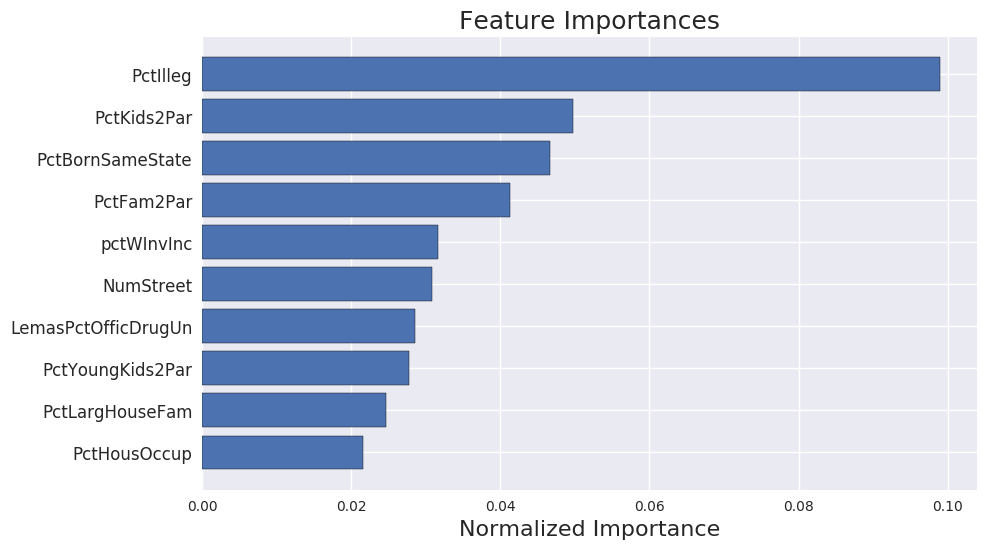

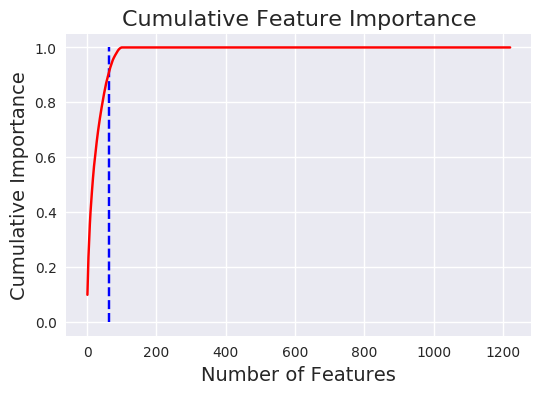

62 features required for 0.90 of cumulative importance


In [36]:
sns.set()
# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                             early_stopping = True)
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

# plot the feature importances
fs.plot_feature_importances(threshold = 0.90, plot_n = 10)

#Building the Model with Limited Features

###Discrete Targets

In [0]:
limited_data = community_data_class[["PctIlleg", "PctKids2Par", "racePctWhite", "PctPopUnderPov", "PctVacantBoarded", "ViolentCrimeLevel"]]
limited_data.head()

In [0]:
#Create X and y datasets with limited data
X_limited = limited_data.copy()
X_limited = X_limited.drop(['ViolentCrimeLevel'], axis=1)
y_limited = limited_data['ViolentCrimeLevel'].copy()

X_train_limited, X_test_limited, y_train_limited, y_test_limited = train_test_split(X_limited, y_limited, random_state=0, test_size=0.2)
X_test_limited.head()

In [0]:
#Set up data for model building
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.layers import Dense, Dropout

print(X_train_limited.shape)
print(y_train_limited.shape)
print(X_test_limited.shape)
print(y_test_limited.shape)

X_train_limited = np.asarray(X_train_limited)
y_train_limited = np.asarray(y_train_limited)
X_test_limited = np.asarray(X_test_limited)
y_test_limited = np.asarray(y_test_limited)

X_train_limited = tf.convert_to_tensor(X_train_limited, dtype=tf.float32)
y_train_limited  = tf.convert_to_tensor(y_train_limited, dtype=tf.string)
X_test_limited = tf.convert_to_tensor(X_test_limited, dtype=tf.float32)
y_test_limited  = tf.convert_to_tensor(y_test_limited, dtype=tf.string)

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

#Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train_limited)
encoded_Y = encoder.transform(y_train_limited)
#Convert integers to dummy variables (i.e. one hot encoded)
y_train_limited = np_utils.to_categorical(encoded_Y)

#Encode class values as integers
encoder2 = LabelEncoder()
encoder2.fit(y_test_limited)
encoded_Y = encoder2.transform(y_test_limited)
#Convert integers to dummy variables (i.e. one hot encoded)
y_test_limited = np_utils.to_categorical(encoded_Y)

In [0]:
layers = [
    Dense(10, input_shape=(5,), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dense((3), activation = 'softmax')
]
model_community = keras.Sequential(layers)

model_community.compile(optimizer='adam', loss='mae', metrics=["accuracy"])
model_community.fit(X_train_limited, y_train_limited, epochs=500, verbose=0)
model_community.summary()
model_community.evaluate(X_test_limited, y_test_limited)

###Continuous Targets

In [0]:
#Create X and y datasets with limited data
limited_data = community_data[["PctIlleg", "PctKids2Par", "racePctWhite", "PctPopUnderPov", "PctVacantBoarded", "ViolentCrimesPerPop"]]
X_limited = limited_data.copy()
X_limited = X_limited.drop(['ViolentCrimesPerPop'], axis=1)
y_limited = limited_data['ViolentCrimesPerPop'].copy()

X_train_limited, X_test_limited, y_train_limited, y_test_limited = train_test_split(X_limited, y_limited, random_state=0, test_size=0.2)
X_test_limited.head()
limited_data.head()

In [0]:
#Set up data for model building
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.layers import Dense, Dropout

print(X_train_limited.shape)
print(y_train_limited.shape)
print(X_test_limited.shape)
print(y_test_limited.shape)

X_train_limited = np.asarray(X_train_limited)
y_train_limited = np.asarray(y_train_limited)
X_test_limited = np.asarray(X_test_limited)
y_test_limited = np.asarray(y_test_limited)

X_train_limited = tf.convert_to_tensor(X_train_limited, dtype=tf.float32)
y_train_limited  = tf.convert_to_tensor(y_train_limited, dtype=tf.float32)
X_test_limited = tf.convert_to_tensor(X_test_limited, dtype=tf.float32)
y_test_limited  = tf.convert_to_tensor(y_test_limited, dtype=tf.float32)

In [0]:
layers = [
    Dense(10, input_shape=(5,), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dense(1)
]
model_community = keras.Sequential(layers)

model_community.compile(optimizer='adam', loss='mae', metrics=["mae", "mse"])
model_community.fit(X_train_limited, y_train_limited, epochs=500, verbose=0)
model_community.summary()
model_community.evaluate(X_test_limited, y_test_limited)

In [0]:
#Try giving it some input values
high = np.asarray([[0.33,	0.54,	0.08,	0.10,	0.60]])
y_new_high = model_community.predict(high)
print(y_new_high)

#Investigating relationship with poverty

In [0]:
#Correlations of limited data
corr = limited_data.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Blues)
plt.show()

### Continuous Targets

In [0]:
#Predict using poverty
#Create X and y datasets with limited data
limited_data = community_data[["PctPopUnderPov", "ViolentCrimesPerPop"]]
X_limited = limited_data.copy()
X_limited = X_limited.drop(['ViolentCrimesPerPop'], axis=1)
y_limited = limited_data['ViolentCrimesPerPop'].copy()

X_train_limited, X_test_limited, y_train_limited, y_test_limited = train_test_split(X_limited, y_limited, random_state=0, test_size=0.2)
X_test_limited.head()

In [0]:
#Set up data for model building
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.layers import Dense, Dropout

print(X_train_limited.shape)
print(y_train_limited.shape)
print(X_test_limited.shape)
print(y_test_limited.shape)

X_train_limited = np.asarray(X_train_limited)
y_train_limited = np.asarray(y_train_limited)
X_test_limited = np.asarray(X_test_limited)
y_test_limited = np.asarray(y_test_limited)

X_train_limited = tf.convert_to_tensor(X_train_limited, dtype=tf.float32)
y_train_limited  = tf.convert_to_tensor(y_train_limited, dtype=tf.float32)
X_test_limited = tf.convert_to_tensor(X_test_limited, dtype=tf.float32)
y_test_limited  = tf.convert_to_tensor(y_test_limited, dtype=tf.float32)

In [0]:
layers = [
    Dense(10, input_shape=(1,), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense(1, activation = 'tanh')
]
model_community = keras.Sequential(layers)

model_community.compile(optimizer='adam', loss='mae', metrics=["mae", "mse"])
model_community.fit(X_train_limited, y_train_limited, epochs=500, verbose=0)
model_community.summary()
model_community.evaluate(X_test_limited, y_test_limited)

In [0]:
#Try giving it some input values
low = np.asarray([[0.2]])
y_new_low = model_community.predict(low)
print(y_new_low)

med = np.asarray([[0.5]])
y_new_med = model_community.predict(med)
print(y_new_med)

high = np.asarray([[0.99]])
y_new_high = model_community.predict(high)
print(y_new_high)

In [0]:
#Try using linear regression as well
limited_data = community_data[["PctPopUnderPov", "ViolentCrimesPerPop"]]
X_limited = limited_data.copy()
X_limited = X_limited.drop(['ViolentCrimesPerPop'], axis=1)
y_limited = limited_data['ViolentCrimesPerPop'].copy()

X_train_limited, X_test_limited, y_train_limited, y_test_limited = train_test_split(X_limited, y_limited, random_state=0, test_size=0.2)

In [0]:
#Create regression object
regressor_limited = LinearRegression()  

#Fit it to our training data
regressor_limited.fit(X_train_limited, y_train_limited)

#Used fitted model to predict values
y_pred_limited = regressor_limited.predict(X_test_limited)

#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_limited, y_pred_limited))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_limited, y_pred_limited))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_limited, y_pred_limited)))
print('Coefficient of Determination (R-squared):', metrics.r2_score(y_test_limited, y_pred_limited))

In [0]:
#Try giving it some input values
low = np.asarray([[0.2]])
y_new_low = regressor_limited.predict(low)
print(y_new_low)

med = np.asarray([[0.5]])
y_new_med = regressor_limited.predict(med)
print(y_new_med)

high = np.asarray([[1.0]])
y_new_high = regressor_limited.predict(high)
print(y_new_high)

###Discrete Targets

In [0]:
limited_data = community_data_class[["PctPopUnderPov", "ViolentCrimeLevel"]]
limited_data.head()
#Create X and y datasets with limited data
X_limited = limited_data.copy()
X_limited = X_limited.drop(['ViolentCrimeLevel'], axis=1)
y_limited = limited_data['ViolentCrimeLevel'].copy()

X_train_limited, X_test_limited, y_train_limited, y_test_limited = train_test_split(X_limited, y_limited, random_state=0, test_size=0.2)
X_test_limited.head()

In [0]:
#Set up data for model building
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.layers import Dense, Dropout

print(X_train_limited.shape)
print(y_train_limited.shape)
print(X_test_limited.shape)
print(y_test_limited.shape)

X_train_limited = np.asarray(X_train_limited)
y_train_limited = np.asarray(y_train_limited)
X_test_limited = np.asarray(X_test_limited)
y_test_limited = np.asarray(y_test_limited)

X_train_limited = tf.convert_to_tensor(X_train_limited, dtype=tf.float32)
y_train_limited  = tf.convert_to_tensor(y_train_limited, dtype=tf.string)
X_test_limited = tf.convert_to_tensor(X_test_limited, dtype=tf.float32)
y_test_limited  = tf.convert_to_tensor(y_test_limited, dtype=tf.string)

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

#Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train_limited)
encoded_Y = encoder.transform(y_train_limited)
#Convert integers to dummy variables (i.e. one hot encoded)
y_train_limited = np_utils.to_categorical(encoded_Y)

#Encode class values as integers
encoder2 = LabelEncoder()
encoder2.fit(y_test_limited)
encoded_Y = encoder2.transform(y_test_limited)
#Convert integers to dummy variables (i.e. one hot encoded)
y_test_limited = np_utils.to_categorical(encoded_Y)

In [0]:
layers = [
    Dense(10, input_shape=(1,), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dropout(0.05),
    Dense((10), activation = 'tanh'),
    Dense((3), activation = 'softmax')
]
model_community = keras.Sequential(layers)

model_community.compile(optimizer='adam', loss='mae', metrics=["accuracy"])
model_community.fit(X_train_limited, y_train_limited, epochs=500, verbose=0)
model_community.summary()
model_community.evaluate(X_test_limited, y_test_limited)